In [42]:
# Import important libraries

import numpy as np
import sympy as sp
import scipy.integrate as integrate

In [43]:
a1 = 1.5
a2 = 1
a3 = 0.5
a = np.array([a1, a2, a3])

eps11 = 0.001
eps22 = 0.001
eps33 = 0.001
eps12 = 0
eps13 = 0
eps23 = 0
app_strain = np.array([[eps11,eps12,eps13],[eps12,eps22,eps23],[eps13,eps23,eps33]])

nu = 0.3
E = 210

delta = np.identity(3)

In [44]:
# Solving the cubis equation of lambda (page 86 of Mura's book, equation 11.37)
def get_lambda(x,a):
    sym = sp.Symbol('lambda_')
    equation = (x[0]**2)/(a[0]**2 + sym) + (x[1]**2)/(a[1]**2 + sym) + (x[2]**2)/(a[2]**2 + sym) - 1
    sol =  sp.solve(equation, sym)
    #print("Solution of Lambda: ",sol)

    # Convert sol to complex number
    sol = [complex(i) for i in sol]
    #print(sol)

    # Select the real part of the solution
    sol = [i.real for i in sol]
    #print(sol)
    
    sol = max(sol)
    if sol > 0:
        lambda_ = sol
    else:
        lambda_ = 0
    return lambda_
    #print("lambda = ",lambda_)

In [45]:
# Defining elliptic integrals and solving them. (page 85 of Mura's book, equation 11.36) lambda=0.. verified for lambda = 0
def I_(x,a, lambda_):
    #lambda_ = get_lambda(x,a)
    def integrand(s):
        return 1/np.sqrt((a[0]**2 + s)*(a[1]**2 + s)*(a[2]**2 + s))
    inte = integrate.quad(integrand, lambda_, np.inf)[0]
    return inte*np.pi*2*a[0]*a[1]*a[2]

def Ii_(x,a, lambda_):
    #lambda_ = get_lambda(x,a)
    arr = np.zeros(3)
    for i in range(3):
        def integrand(s):
            return (1/(np.sqrt((a[0]**2 + s)*(a[1]**2 + s)*(a[2]**2 + s))*(a[i]**2 + s)))
        inte = integrate.quad(integrand, lambda_, np.inf)[0]
        arr[i] = inte*np.pi*2*a[0]*a[1]*a[2]
    return arr

def Iij_(x,a, lambda_):
    #lambda_ = get_lambda(x,a)
    #print("lambda = ",lamb)
    arr = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            def integrand(s):
                return (1/(np.sqrt((a[0]**2 + s)*(a[1]**2 + s)*(a[2]**2 + s))*(a[i]**2 + s)*(a[j]**2 + s)))
            inte = integrate.quad(integrand, lambda_, np.inf)[0]
            arr[i,j] = inte*np.pi*2*a[0]*a[1]*a[2]
    return arr

In [46]:
# Compute Sijkl (page 88 of Mura's book, equation 11.42)

def get_Sijkl(x,a,I,Ii,Iij):
    Sijkl = np.zeros((3,3,3,3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    t1 = delta[i,j]*delta[k,l]*(2*nu*Ii[i] - Ii[k] + (a[i]**2)*Iij[k,i])
                    t2 = (delta[i,k]*delta[j,l] + delta[i,l]*delta[j,k])*((a[i]**2)*Iij[i,j] - Ii[j] + (1-nu)*(Ii[k] + Ii[l]))
                    Sijkl[i,j,k,l] = (t1+t2)/(8*np.pi*(1-nu))
                    #print("S",i+1,j+1,k+1,l+1," = ",Sijkl[i,j,k,l])
    return Sijkl

In [47]:
# Compute derivatives of elliptic integrals (page 86 of Mura's book, equation 11.39)
# Compute derivative of lambda wrt to 3 directions
def lamb_der(x,a,lambda_):
    arr = []
    #Check if x in inside
    if (x[0]**2/(a[0]**2)) + (x[1]**2/(a[1]**2)) + (x[2]**2/(a[2]**2)) <= 1:
        return [0,0,0]
    denom = (x[0]**2/(a[0]**2 + lambda_)) + (x[1]**2/(a[1]**2 + lambda_)) + (x[2]**2/(a[2]**2 + lambda_))
    for i in range(3):
        num = (2*x[i])/(a[i]**2 + lambda_)
        arr.append(num/denom)
    return arr

# Compute double derivative matrix of lambda
def lamb_der2(x,a,lambda_,lambda_der):
    arr = np.zeros((3,3))
    #Check if x in inside
    if (x[0]**2/(a[0]**2)) + (x[1]**2/(a[1]**2)) + (x[2]**2/(a[2]**2)) <= 1:
        return arr
    denom = (x[0]**2/(a[0]**2 + lambda_)) + (x[1]**2/(a[1]**2 + lambda_)) + (x[2]**2/(a[2]**2 + lambda_))
    for i in range(3):
        for j in range(3):
            num = 2*denom*lambda_der[i]*lambda_der[j] - 2*(x[i])*lambda_der[j]/(a[i]**2 + lambda_) - 2*(x[j])*lambda_der[i]/(a[j]**2 + lambda_)
            arr[i,j] = num/denom
    return arr

#Compute derivative of Ii wrt to j direction
def Ii_j_(x,a,lambda_,lambda_der):
    arr = np.zeros((3,3))
    c = -2*np.pi*a[0]*a[1]*a[2]
    del_l = ((a[0]**2 + lambda_)*(a[1]**2 + lambda_)*(a[2]**2 + lambda_))**(1/2)
    for i in range(3):
        for j in range(3):
            arr[i,j] = c*lambda_der[j]/((a[i]**2 + lambda_)*del_l)
    return arr

# Compute derivative of Iij wrt to k direction
def Iij_k_(x,a,lambda_,lambda_der):
    arr = np.zeros((3,3,3))
    c = -2*np.pi*a[0]*a[1]*a[2]
    del_l = ((a[0]**2 + lambda_)*(a[1]**2 + lambda_)*(a[2]**2 + lambda_))**(1/2)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                arr[i,j,k] = c*lambda_der[k]/((a[i]**2 + lambda_)*(a[j]**2 + lambda_)*del_l)
    return arr

# Compute double partial derivative of Iij wrt to k and l direction
def Iij_kl_(x,a,lambda_,lambda_der,lambda_der2):
    arr = np.zeros((3,3,3,3))
    c = -2*np.pi*a[0]*a[1]*a[2]
    del_l = ((a[0]**2 + lambda_)*(a[1]**2 + lambda_)*(a[2]**2 + lambda_))**(1/2)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    arr[i,j,k,l] = (c/((a[i]**2 + lambda_)*(a[j]**2 + lambda_)*(del_l)))*(lambda_der2[k,l] - lambda_der[k]*lambda_der[l]*(1/(a[i]**2 + lambda_) + 1/(a[j]**2 + lambda_) + 0.5*(1/(a[0]**2 + lambda_) + 1/(a[1]**2 + lambda_) + 1/(a[2]**2 + lambda_))))
    return arr

# Compute derivative of Ii wrt to j and k direction
def Ii_jk_(x,a,lambda_,lambda_der,lambda_der2):
    arr = np.zeros((3,3,3))
    c = -2*np.pi*a[0]*a[1]*a[2]
    del_l = ((a[0]**2 + lambda_)*(a[1]**2 + lambda_)*(a[2]**2 + lambda_))**(1/2)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                arr[i,j,k] = (c/((a[i]**2 + lambda_)*(del_l)))*(lambda_der2[j,k] - lambda_der[j]*lambda_der[k]*(1/(a[i]**2 + lambda_) + 0.5*(1/(a[0]**2 + lambda_) + 1/(a[1]**2 + lambda_) + 1/(a[2]**2 + lambda_))))
    return arr

In [48]:
# Compute Dijkl (page 87 of Mura's book, equation 11.41)
def get_Dijkl(x,a,S,Ii_j, Iij_k, Iij_kl, Ii_jk):
    Dijkl = np.zeros((3,3,3,3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    t1 = 8*np.pi*(1-nu)*S[i,j,k,l] + 2*nu*delta[k,l]*x[i]*Ii_j[i,j]
                    t2 = (1+nu)*(delta[i,l]*x[k]*Ii_j[k,j] + delta[j,l]*x[k]*Ii_j[k,i] + delta[i,k]*x[l]*Ii_j[l,j] + delta[j,k]*x[l]*Ii_j[l,i])
                    t3 = -delta[i,j]*x[k]*(Ii_j[k,l] + a[i]**2*Iij_k[k,l,l]) - (delta[i,k]*x[j] + delta[j,k]*x[i])*(Ii_j[j,l] - a[i]**2*Iij_k[i,j,l])
                    t4 = -(delta[i,l]*x[j] + delta[j,l]*x[i])*(Ii_j[j,k] - a[i]**2*Iij_k[i,j,k]) - x[i]*x[j]*(Ii_jk[j,l,k] - a[i]**2*Iij_kl[i,j,l,k])
                    Dijkl[i,j,k,l] = (t1+t2+t3+t4)/(8*np.pi*(1-nu))
                    #print("D",i+1,j+1,k+1,l+1," = ",Dijkl[i,j,k,l])
    return Dijkl

In [49]:
# Calculate epsilon tensor (page 85 of Mura's book, equation 11.33)
def get_epsilon(D,app_strain):
    epsilon = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    epsilon[i,j] = epsilon[i,j] + D[i,j,k,l]*app_strain[k,l]
    return epsilon

In [50]:
# Calculate stress tensor for 3D
def get_stress(epsilon,E,nu,app_strain,inside):
    if inside == True:
        epsilon = epsilon - app_strain
    sig11 = (E/((1+nu)*(1-2*nu)))*((1-nu)*epsilon[0,0] + nu*epsilon[1,1] + nu*epsilon[2,2])
    sig22 = (E/((1+nu)*(1-2*nu)))*(nu*epsilon[0,0] + (1-nu)*epsilon[1,1] + nu*epsilon[2,2])
    sig33 = (E/((1+nu)*(1-2*nu)))*(nu*epsilon[0,0] + nu*epsilon[1,1] + (1-nu)*epsilon[2,2])
    sig12 = (E/(1+nu))*epsilon[0,1]
    sig13 = (E/(1+nu))*epsilon[0,2]
    sig23 = (E/(1+nu))*epsilon[1,2]
    return np.array([[sig11,sig12,sig13],[sig12,sig22,sig23],[sig13,sig23,sig33]])

In [51]:
x = np.array([1,0,0])

inside = False
# Check if x is inside ellipsoid
if ((x[0]/a[0])**2 + (x[1]/a[1])**2 + (x[2]/a[2])**2) <= 1:
    inside = True

lambda_ = get_lambda(x,a)
print("lambda = ",lambda_)

I = I_(x,a,lambda_)
Ii = Ii_(x,a,lambda_)
Iij = Iij_(x,a,lambda_)
print("I's are done ")

S = get_Sijkl(x,a,I,Ii,Iij)
print("Sijkl is done ")

lambda_der = lamb_der(x,a,lambda_)
lambda_der2 = lamb_der2(x,a,lambda_,lambda_der)
print("lambda derivatives are done ")

Ii_j = Ii_j_(x,a,lambda_,lambda_der)
Iij_k = Iij_k_(x,a,lambda_,lambda_der)
Iij_kl = Iij_kl_(x,a,lambda_,lambda_der,lambda_der2)
Ii_jk = Ii_jk_(x,a,lambda_,lambda_der,lambda_der2)
print("Ii_j, Iij_k, Iij_kl, Ii_jk are done ")

Dijkl = get_Dijkl(x,a,S,Ii_j, Iij_k, Iij_kl, Ii_jk)
print("Dijkl is done ")

epsilon = get_epsilon(Dijkl,app_strain)
stress = get_stress(epsilon,E,nu,app_strain,inside)
print("stress = ",stress)

lambda =  0
I's are done 
Sijkl is done 
lambda derivatives are done 
Ii_j, Iij_k, Iij_kl, Ii_jk are done 
Dijkl is done 
stress =  [[-0.25310979  0.          0.        ]
 [ 0.         -0.21985379  0.        ]
 [ 0.          0.         -0.12703642]]


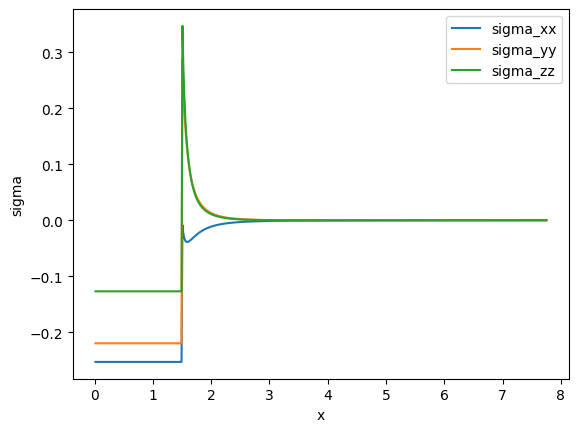

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a dataframe to store the results
df = pd.DataFrame(columns=['x','sigma_xx','sigma_yy','sigma_zz'])

data = pd.read_csv('plot3d.csv')
x1 = data['x']
y1 = data['y']
z1 = data['z']

sigma_xx = []
sigma_yy = []
sigma_zz = []
for i in range(len(x1)):
    x = np.array([x1[i],y1[i],z1[i]])
    inside = False
    # Check if x is inside ellipsoid
    if ((x[0]/a[0])**2 + (x[1]/a[1])**2 + (x[2]/a[2])**2) <= 1:
        inside = True

    lambda_ = get_lambda(x,a)
    #print("lambda = ",lambda_)

    I = I_(x,a,lambda_)
    Ii = Ii_(x,a,lambda_)
    Iij = Iij_(x,a,lambda_)
    #print("I's are done ")

    S = get_Sijkl(x,a,I,Ii,Iij)
    #print("Sijkl is done ")

    lambda_der = lamb_der(x,a,lambda_)
    lambda_der2 = lamb_der2(x,a,lambda_,lambda_der)
    #print("lambda derivatives are done ")

    Ii_j = Ii_j_(x,a,lambda_,lambda_der)
    Iij_k = Iij_k_(x,a,lambda_,lambda_der)
    Iij_kl = Iij_kl_(x,a,lambda_,lambda_der,lambda_der2)
    Ii_jk = Ii_jk_(x,a,lambda_,lambda_der,lambda_der2)
    #print("Ii_j, Iij_k, Iij_kl, Ii_jk are done ")

    Dijkl = get_Dijkl(x,a,S,Ii_j, Iij_k, Iij_kl, Ii_jk)
    #print("Dijkl is done ")

    epsilon = get_epsilon(Dijkl,app_strain)
    stress = get_stress(epsilon,E,nu,app_strain,inside)
    #print("stress = ",stress)

    sigma_xx.append(stress[0,0])
    sigma_yy.append(stress[1,1])
    sigma_zz.append(stress[2,2])
    print(x[0])

plt.plot(x1,sigma_xx,label="sigma_xx")
plt.plot(x1,sigma_yy,label="sigma_yy")
plt.plot(x1,sigma_zz,label="sigma_zz")
plt.legend()
plt.xlabel("x")
plt.ylabel("sigma")
plt.show()

# Save the arrays sigma_xx, sigma_yy and sigma_zz in a dataframe
df = pd.DataFrame({'x':x1,'sigma_xx':sigma_xx,'sigma_yy':sigma_yy,'sigma_zz':sigma_zz})

# Save the dataframe to a csv file
df.to_csv("stress.csv",index=False)